# Final Project - Reinforcements Learning 
<br>

### Name and ID:
Student 1: Hadar Pur
<br>
Student 2: Ron Azuelos
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

# Imports

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from scipy.spatial.distance import cityblock
import cv2


import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from google.colab import drive

In [3]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14, 6)})

In [57]:
!gdown 1Q60AiJVw1soXiQO07AkjKVoOy-qNy27P

Downloading...
From: https://drive.google.com/uc?id=1Q60AiJVw1soXiQO07AkjKVoOy-qNy27P
To: /content/final_project_models.zip
100% 8.54M/8.54M [00:00<00:00, 15.6MB/s]


In [73]:
!unzip /content/final_project_models.zip

Archive:  /content/final_project_models.zip
   creating: models/
   creating: models/ex1/
  inflating: models/ex1/a2c.pt       
  inflating: models/ex1/a2c_full.mp4  
  inflating: models/ex1/a2c_mid.mp4  
  inflating: models/ex1/dqn.pt       
  inflating: models/ex1/dqn_full.mp4  
  inflating: models/ex1/dqn_mid.mp4  
   creating: models/ex2/
   creating: models/ex2/2/
  inflating: models/ex2/2/a2c.pt     
  inflating: models/ex2/2/a2c_full.mp4  
  inflating: models/ex2/2/a2c_mid.mp4  
  inflating: models/ex2/a2c.pt       
  inflating: models/ex2/a2c_full.mp4  
  inflating: models/ex2/a2c_mid.mp4  
  inflating: models/ex2/dqn.pt       
  inflating: models/ex2/dqn_full.mp4  
  inflating: models/ex2/dqn_mid.mp4  


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [7]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Given an environment and agent, it will generate a video of the agent in the environment and display it

In [8]:
def generate_video(env, agent, file_name, seed=2):
  with imageio.get_writer(file_name, fps=10) as video:
    # reset env
    random.seed(seed)
    state = env.reset()
    state = agent.state_to_tensor(state)

    # add first frame
    video.append_data(env.render(mode='rgb_array'))

    # init parameters
    done = False
    while not done:
      # select action
      action = agent.select_action(state)

      # do step
      next_state, reward, done, info = env.step(action.item())
      next_state = agent.state_to_tensor(next_state)

      # add frame to video
      video.append_data(env.render(mode='rgb_array'))

      state = next_state

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [9]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox mapping: {env.box_mapping}')

This function is used to generate a line plot of the steps/rewards in each episode, or the average of them over the last 100 episodes

In [10]:
def generate_reward_graph(episode_data, y_label, avg=False):
  data = episode_data
  if avg:
    data = [np.mean(data[max(0,i-100):i]) for i in range(1, len(data))]
  x_label = 'Episodes'
  df = pd.DataFrame(data={x_label: list(range(len(data))), y_label: data})
  return sns.lineplot(data=df, x=x_label, y=y_label)

# Algorithm 


## DQN

In [11]:
class DQN():
  def __init__(self, env, batch_size=128, discount_factor=0.99, epsilon=0.9,
               min_epsilon=0.05, num_episodes=500, replay_buffer_size=10000, 
               max_steps_per_episode=500, learning_rate=1e-4, tau=0.005,
               fixed_env=True, reward_shaping=False):
    self.env = env
    self.input_space = env.observation_space.shape
    self.num_actions = env.action_space.n
    
    self.batch_size = batch_size
    self.discount_factor = discount_factor
    self.epsilon = epsilon
    self.max_epsilon = epsilon
    self.min_epsilon = min_epsilon
    self.decay_rate = 100000 if fixed_env else 500000
    self.num_episodes = num_episodes
    self.replay_buffer_size = replay_buffer_size
    self.max_steps_per_episode = max_steps_per_episode
    self.fixed_env = fixed_env
    self.tau = tau

    self.reward_shaping = reward_shaping
    self.state_potential = 0

    self.model = self.__create_model()
    self.target_model = self.__create_model()
    self.target_model.load_state_dict(self.model.state_dict())

    self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, amsgrad=True)

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.episode_rewards = []
    self.episode_durations = []

  def __create_model(self):
    model = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=8, stride=4),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(2304, self.num_actions)
    )

    if torch.cuda.is_available():
      model.cuda()

    return model

  def load_model(self, checkpoint_path):
    data_dict = torch.load(os.path.join(checkpoint_path, f'dqn.pt'))
    self.model.load_state_dict(data_dict['model'])
    self.target_model.load_state_dict(data_dict['target'])
    self.optimizer.load_state_dict(data_dict['optimizer'])
    self.episode_rewards = data_dict['episode_rewards']
    self.episode_durations = data_dict['episode_durations']
    self.model.eval()
    self.target_model.eval()

  def save_model(self, checkpoint_path):
    data_dict = {
      'model': self.model.state_dict(),
      'target': self.target_model.state_dict(),
      'optimizer': self.optimizer.state_dict(),
      'episode_rewards': self.episode_rewards,
      'episode_durations': self.episode_durations
    }
    torch.save(data_dict, os.path.join(checkpoint_path, f'dqn.pt'))
  
  def calc_state_potential(self):
    total_distance = 0
    player = self.env.player_position
    goals = set(self.env.box_mapping.keys())
    boxes = np.transpose(((self.env.room_state == 4) + (self.env.room_state == 3)).nonzero())
    boxes = set(map(tuple, boxes))
    boxes_on_goals = boxes & goals
    for g in (goals - boxes_on_goals):
      for b in (boxes - boxes_on_goals):
        total_distance -= cityblock(b, g)
    return total_distance / 10

  def shape_reward(self, reward, info):
    if not self.reward_shaping:
      return reward
    
    # by action (if not moved player)
    if not info['action.moved_player']:
      reward = reward - 1.0

    # by distance (if moved box)
    if info['action.moved_box']:
      next_state_potential = self.calc_state_potential()
      reward = reward + next_state_potential - self.state_potential
      self.state_potential = next_state_potential

    return reward

  def transform_state(self, state):
    # crop edges
    state = state[16:-16, 16:-16]

    # convert to gray scale
    state = 0.299 * state[:, :, 0] + 0.587 * state[:, :, 1] + 0.114 * state[:, :, 2]

    return state

  def state_to_tensor(self, state):
    state = self.transform_state(state)
    state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
    state_tensor = state_tensor.unsqueeze(0).unsqueeze(0)
    return state_tensor

  def decay_epsilon(self, total_steps):
    self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-1. * total_steps / 100000)
    return self.epsilon

  def select_action(self, state_tensor):
    return self.select_action_epsilon_greedy(state_tensor, use_epsilon=False)

  def select_action_epsilon_greedy(self, state_tensor, use_epsilon=True):
    if use_epsilon and self.epsilon > np.random.rand(1)[0]:
      action = torch.tensor([self.env.action_space.sample()], dtype=torch.long, device=self.device)
    else:
      with torch.no_grad():
        action = self.model(state_tensor).max(1)[1].view(1)
    return action

  def update_model(self, replay_buffer):
    if len(replay_buffer) < self.batch_size:
      return
    
    batch_samples = random.sample(replay_buffer, self.batch_size)
    batch_samples = list(zip(*batch_samples))

    batch_states = torch.cat(batch_samples[0])
    batch_actions = torch.stack(batch_samples[1])
    batch_rewards = torch.cat(batch_samples[2])
    batch_next_states = torch.cat(batch_samples[3])
    batch_dones = torch.tensor(batch_samples[4], dtype=torch.bool, device=self.device).long()

    # get the Q-values of each next_state from target_model and choose the max
    with torch.no_grad():
      q_max_action_from_target = self.target_model(batch_next_states).max(1)[0]

    # y_j = r_j + (gamma * max_q_target) if episode is not done at step j+1 else 0
    y_j = batch_rewards + ((self.discount_factor * q_max_action_from_target) * (1 - batch_dones))

    # the action values
    q_action = self.model(batch_states).gather(1, batch_actions)

    # compute loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(q_action, y_j.unsqueeze(1))

    # back propagation
    self.optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(self.model.parameters(), 100)
    self.optimizer.step()

  def update_target_model(self):
    target_weights = self.target_model.state_dict()
    model_weights = self.model.state_dict()
    for w in model_weights:
      target_weights[w] = model_weights[w] * self.tau + target_weights[w] * (1 - self.tau)
    self.target_model.load_state_dict(target_weights)

  def train(self, checkpoint_path):
    steps_done = 0
    replay_buffer = []

    for episode in range(self.num_episodes):
      random.seed(2 if self.fixed_env else episode)
      state = self.env.reset()
      state = self.state_to_tensor(state)
      self.state_potential = self.calc_state_potential()
      episode_reward = 0

      for step in range(self.max_steps_per_episode):
        steps_done += 1

        # select action epsilon-greedy
        action = self.select_action_epsilon_greedy(state)

        # execute action in the environment
        next_state, reward, done, info = self.env.step(action.item())
        next_state = self.state_to_tensor(next_state)
        reward = self.shape_reward(reward, info)
        episode_reward += reward
        reward = torch.tensor([reward], device=self.device)

        # add transition to experience replay buffer
        real_done = done and info['all_boxes_on_target']
        replay_buffer.append([state, action, reward, next_state, real_done])
        state = next_state

        # update model with experience replay
        self.update_model(replay_buffer)

        # soft update of the target network's weights
        self.update_target_model()
        
        # decay epsilon
        eps = self.decay_epsilon(steps_done)

        # update replay buffer 
        if len(replay_buffer) > self.replay_buffer_size:
          replay_buffer = replay_buffer[1:]

        if done:
          self.episode_rewards.append(episode_reward)
          self.episode_durations.append(step + 1)
          print(f'Episode {episode + 1:>3}/{self.num_episodes} - reward={episode_reward:.2f}\teps={eps:.2f}')
          break

      if episode % 100 == 0:
        self.save_model(checkpoint_path)

      # generate video file - middle of training
      if episode == self.num_episodes // 2:
        generate_video(self.env, self, os.path.join(checkpoint_path, 'dqn_mid.mp4'))

    # generate video file - complete training
    generate_video(self.env, self, os.path.join(checkpoint_path, 'dqn_full.mp4'))
    self.save_model(checkpoint_path)

## A2C

In [12]:
class ActorCriticModel(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCriticModel, self).__init__()
        self.conv1 = nn.Conv2d(input_shape, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()
        self.actor = nn.Linear(2304, num_actions)
        self.critic = nn.Linear(2304, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        actor_output = F.softmax(self.actor(x), dim=1)
        critic_output = self.critic(x)
        return actor_output, critic_output

In [13]:
class A2C():
  def __init__(self, env, batch_size=128, discount_factor=0.99, epsilon=0.9,
               min_epsilon=0.05, num_episodes=500, replay_buffer_size=10000, 
               max_steps_per_episode=500, learning_rate=1e-4, entropy_coef=0.1,
               fixed_env=True, reward_shaping=False):
    self.env = env
    self.input_space = env.observation_space.shape
    self.num_actions = env.action_space.n
    
    self.batch_size = batch_size
    self.discount_factor = discount_factor
    self.epsilon = epsilon
    self.max_epsilon = epsilon
    self.min_epsilon = min_epsilon
    self.decay_rate = 100000 if fixed_env else 500000
    self.num_episodes = num_episodes
    self.replay_buffer_size = replay_buffer_size
    self.max_steps_per_episode = max_steps_per_episode
    self.entropy_coef = entropy_coef
    self.fixed_env = fixed_env
    self.reward_shaping = reward_shaping

    self.model = ActorCriticModel(input_shape=1, num_actions=self.num_actions)
    if torch.cuda.is_available():
      self.model.cuda()

    self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, amsgrad=True)

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.episode_rewards = []
    self.episode_durations = []

  def load_model(self, checkpoint_path):
    data_dict = torch.load(os.path.join(checkpoint_path, f'a2c.pt'))
    self.model.load_state_dict(data_dict['model'])
    self.optimizer.load_state_dict(data_dict['optimizer'])
    self.episode_rewards = data_dict['episode_rewards']
    self.episode_durations = data_dict['episode_durations']
    self.model.eval()

  def save_model(self, checkpoint_path):
    data_dict = {
      'model': self.model.state_dict(),
      'optimizer': self.optimizer.state_dict(),
      'episode_rewards': self.episode_rewards,
      'episode_durations': self.episode_durations
    }
    torch.save(data_dict, os.path.join(checkpoint_path, f'a2c.pt'))
  
  def calc_state_potential(self):
    total_distance = 0
    player = self.env.player_position
    goals = set(self.env.box_mapping.keys())
    boxes = np.transpose(((self.env.room_state == 4) + (self.env.room_state == 3)).nonzero())
    boxes = set(map(tuple, boxes))
    boxes_on_goals = boxes & goals
    for g in (goals - boxes_on_goals):
      for b in (boxes - boxes_on_goals):
        total_distance -= cityblock(b, g)
    return total_distance / 10

  def shape_reward(self, reward, info):
    if not self.reward_shaping:
      return reward
    
    # by action (if not moved player)
    if not info['action.moved_player']:
      reward = reward - 1.0

    # by distance (if moved box)
    if info['action.moved_box']:
      next_state_potential = self.calc_state_potential()
      reward = reward + next_state_potential - self.state_potential
      self.state_potential = next_state_potential

    return reward

  def transform_state(self, state):
    # crop edges
    state = state[16:-16, 16:-16]

    # convert to gray scale
    state = 0.299 * state[:, :, 0] + 0.587 * state[:, :, 1] + 0.114 * state[:, :, 2]

    return state

  def state_to_tensor(self, state):
    state = self.transform_state(state)
    state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
    state_tensor = state_tensor.unsqueeze(0).unsqueeze(0)
    return state_tensor

  def decay_epsilon(self, total_steps):
    self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-1. * total_steps / 100000)
    return self.epsilon

  def select_action(self, state_tensor):
    return self.select_action_epsilon_greedy(state_tensor, use_epsilon=False)

  def select_action_epsilon_greedy(self, state_tensor, use_epsilon=True):
    if use_epsilon and self.epsilon > np.random.rand(1)[0]:
      action = torch.tensor([self.env.action_space.sample()], dtype=torch.long, device=self.device)
    else:
      with torch.no_grad():
        action = self.model(state_tensor)[0].max(1)[1].view(1)
    return action

  def update_model(self, replay_buffer):
    if len(replay_buffer) < self.batch_size:
      return
    
    batch_samples = random.sample(replay_buffer, self.batch_size)
    batch_samples = list(zip(*batch_samples))

    batch_states = torch.cat(batch_samples[0])
    batch_actions = torch.stack(batch_samples[1])
    batch_rewards = torch.cat(batch_samples[2])
    batch_next_states = torch.cat(batch_samples[3])
    batch_dones = torch.tensor(batch_samples[4], dtype=torch.bool, device=self.device).long()

    action_probs, values = self.model(batch_states)
    _, next_values = self.model(batch_next_states)

    # Compute advantages
    returns = batch_rewards + self.discount_factor * next_values.squeeze(1) * (1 - batch_dones)

    # Compute actor loss
    advantages = returns - values.squeeze(1)
    action_dist = Categorical(action_probs)
    log_probs = action_dist.log_prob(batch_actions.squeeze(1))
    entropy = action_dist.entropy().mean()
    actor_loss = -(advantages.detach() * log_probs).mean()

    # compute critic loss
    criterion = nn.SmoothL1Loss()
    critic_loss = criterion(values, returns.unsqueeze(1).detach())

    # back propagation
    loss = actor_loss + 0.5 * critic_loss - self.entropy_coef * entropy
    
    self.optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(self.model.parameters(), 100)
    self.optimizer.step()

  def train(self, checkpoint_path):
    steps_done = 0
    replay_buffer = []

    for episode in range(self.num_episodes):
      random.seed(2 if self.fixed_env else episode)
      state = self.env.reset()
      state = self.state_to_tensor(state)
      self.state_potential = self.calc_state_potential()
      episode_reward = 0

      for step in range(self.max_steps_per_episode):
        steps_done += 1

        # select action epsilon-greedy
        action = self.select_action_epsilon_greedy(state)

        # execute action in the environment
        next_state, reward, done, info = self.env.step(action.item())
        next_state = self.state_to_tensor(next_state)
        reward = self.shape_reward(reward, info)
        episode_reward += reward
        reward = torch.tensor([reward], device=self.device)

        # add transition to experience replay buffer
        real_done = done and info['all_boxes_on_target']
        replay_buffer.append([state, action, reward, next_state, real_done])
        state = next_state

        # update model with experience replay
        self.update_model(replay_buffer)
        
        # decay epsilon
        eps = self.decay_epsilon(steps_done)

        # update replay buffer 
        if len(replay_buffer) > self.replay_buffer_size:
          replay_buffer = replay_buffer[1:]

        if done:
          self.episode_rewards.append(episode_reward)
          self.episode_durations.append(step + 1)
          print(f'Episode {episode + 1}/{self.num_episodes} - reward={episode_reward:.2f}\teps={eps:.2f}')
          break

      if episode % 100 == 0:
        self.save_model(checkpoint_path)

      # generate video file - middle of training
      if episode == self.num_episodes // 2:
        generate_video(self.env, self, os.path.join(checkpoint_path, 'a2c_mid.mp4'))

    # generate video file - complete training
    generate_video(self.env, self, os.path.join(checkpoint_path, 'a2c_full.mp4'))
    self.save_model(checkpoint_path)

# Experiments

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [14]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 4]
Box mapping: {(4, 2): (3, 4)}


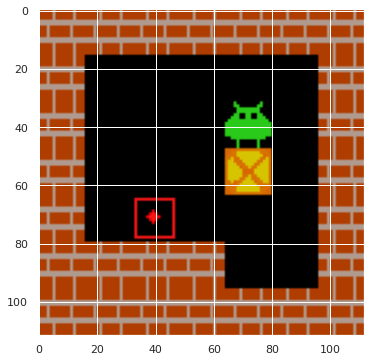

In [15]:
random.seed(2)
sok.reset()
screen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
observation, reward, done, _ = sok.step(1)
print_env_det(sok)

In [16]:
checkpoint_path = 'models/ex1'

### EX1 - DQN

#### Training - NO NEED TO RUN

In [ ]:
sok.seed(2)
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
agent_dqn_ex1 = DQN(sok, num_episodes=200)
agent_dqn_ex1.train(checkpoint_path=checkpoint_path)

Episode   1/200 - reward=-23.00	eps=0.90
Episode   2/200 - reward=-37.10	eps=0.89
Episode   3/200 - reward=-50.00	eps=0.89
Episode   4/200 - reward=-36.40	eps=0.88
Episode   5/200 - reward=-50.00	eps=0.88
Episode   6/200 - reward=-50.00	eps=0.88
Episode   7/200 - reward=-50.00	eps=0.87
Episode   8/200 - reward=-50.00	eps=0.87
Episode   9/200 - reward=-30.40	eps=0.86
Episode  10/200 - reward=2.50	eps=0.86
Episode  11/200 - reward=-50.00	eps=0.86
Episode  12/200 - reward=-50.00	eps=0.86
Episode  13/200 - reward=-50.00	eps=0.85
Episode  14/200 - reward=-50.00	eps=0.85
Episode  15/200 - reward=-50.00	eps=0.84
Episode  16/200 - reward=7.70	eps=0.84
Episode  17/200 - reward=-34.40	eps=0.84
Episode  18/200 - reward=-32.10	eps=0.84
Episode  19/200 - reward=-50.00	eps=0.83
Episode  20/200 - reward=-50.00	eps=0.83
Episode  21/200 - reward=-19.00	eps=0.83
Episode  22/200 - reward=9.10	eps=0.83
Episode  23/200 - reward=-36.40	eps=0.82
Episode  24/200 - reward=-50.00	eps=0.82
Episode  25/200 - rewa

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Episode 102/200 - reward=9.30	eps=0.78
Episode 103/200 - reward=8.90	eps=0.78
Episode 104/200 - reward=9.00	eps=0.78
Episode 105/200 - reward=-1.20	eps=0.78
Episode 106/200 - reward=9.20	eps=0.78
Episode 107/200 - reward=9.10	eps=0.78
Episode 108/200 - reward=8.30	eps=0.77
Episode 109/200 - reward=9.20	eps=0.77
Episode 110/200 - reward=9.10	eps=0.77
Episode 111/200 - reward=9.50	eps=0.77
Episode 112/200 - reward=9.00	eps=0.77
Episode 113/200 - reward=9.10	eps=0.77
Episode 114/200 - reward=8.90	eps=0.77
Episode 115/200 - reward=10.00	eps=0.77
Episode 116/200 - reward=8.90	eps=0.77
Episode 117/200 - reward=9.10	eps=0.77
Episode 118/200 - reward=4.60	eps=0.77
Episode 119/200 - reward=9.10	eps=0.77
Episode 120/200 - reward=9.10	eps=0.77
Episode 121/200 - reward=9.20	eps=0.77
Episode 122/200 - reward=9.10	eps=0.77
Episode 123/200 - reward=9.00	eps=0.77
Episode 124/200 - reward=9.20	eps=0.77
Episode 125/200 - reward=8.70	eps=0.77
Episode 126/200 - reward=9.00	eps=0.77
Episode 127/200 - rewar

#### Load Pre-trained Model

In [17]:
agent_dqn_ex1 = DQN(sok)
agent_dqn_ex1.load_model(checkpoint_path=checkpoint_path)

#### Evaluation

Video of the agent in the middle of the training

In [18]:
embed_mp4(os.path.join(checkpoint_path, 'dqn_mid.mp4'))

Video of the agent after it finished learning and converged

In [19]:
embed_mp4(os.path.join(checkpoint_path, 'dqn_full.mp4'))

The graph below shows the number of steps it took the agent to try to solve the environment in each episode

<AxesSubplot:xlabel='Episodes', ylabel='Steps'>

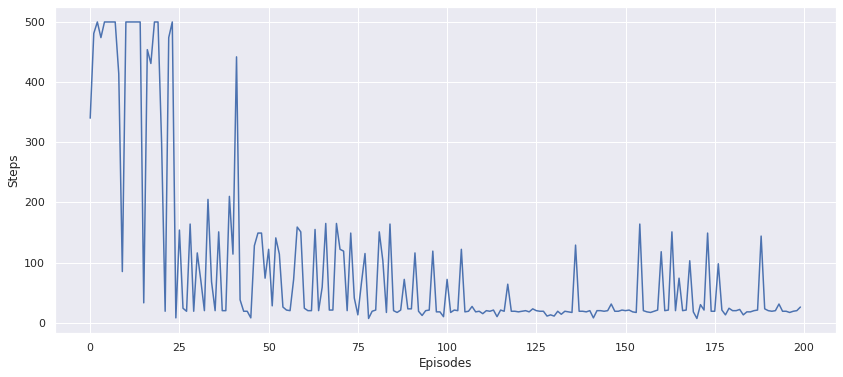

In [20]:
generate_reward_graph(agent_dqn_ex1.episode_durations, y_label='Steps')

The graph below shows the mean number of steps over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Steps'>

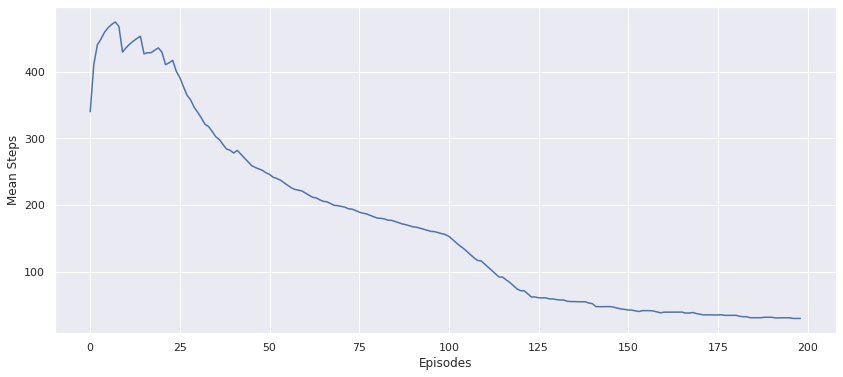

In [21]:
generate_reward_graph(agent_dqn_ex1.episode_durations, y_label='Mean Steps', avg=True)

The graph below shows the cumulative rewards for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Rewards'>

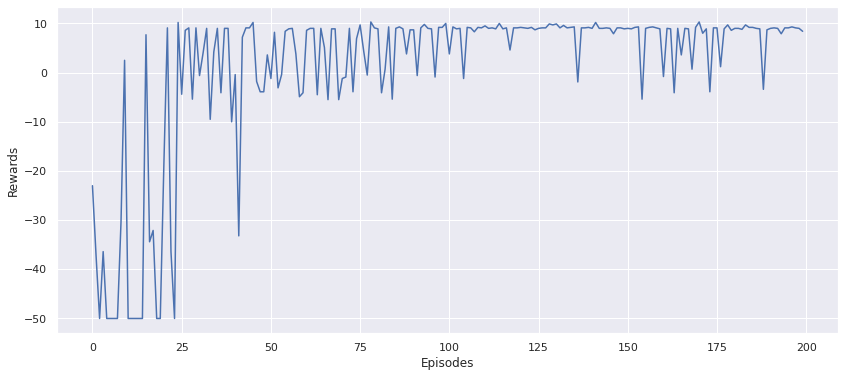

In [22]:
generate_reward_graph(agent_dqn_ex1.episode_rewards, y_label='Rewards')

The graph below shows the mean rewards over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Rewards'>

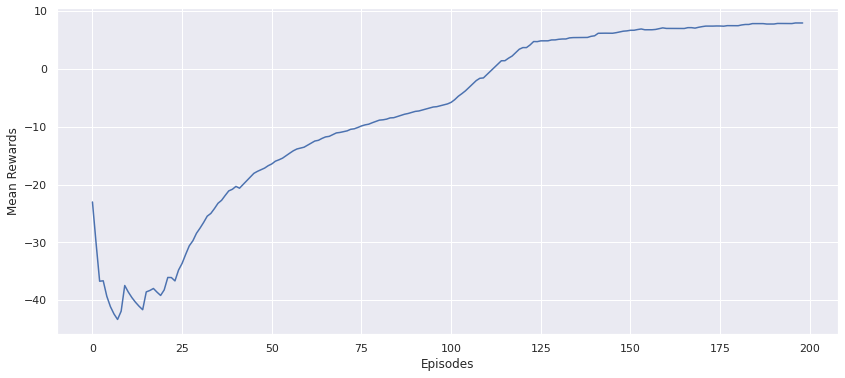

In [23]:
generate_reward_graph(agent_dqn_ex1.episode_rewards, y_label='Mean Rewards', avg=True)

### EX1 - A2C

#### Training - NO NEED TO RUN

In [ ]:
sok.seed(2)
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
agent_a2c_ex1 = A2C(sok, num_episodes=200)
agent_a2c_ex1.train(checkpoint_path=checkpoint_path)

Episode 1/200 - reward=-50.00	eps=0.90
Episode 2/200 - reward=-50.00	eps=0.89
Episode 3/200 - reward=-50.00	eps=0.89
Episode 4/200 - reward=-50.00	eps=0.88
Episode 5/200 - reward=-50.00	eps=0.88
Episode 6/200 - reward=-50.00	eps=0.87
Episode 7/200 - reward=-50.00	eps=0.87
Episode 8/200 - reward=-50.00	eps=0.87
Episode 9/200 - reward=-50.00	eps=0.86
Episode 10/200 - reward=-50.00	eps=0.86
Episode 11/200 - reward=-50.00	eps=0.85
Episode 12/200 - reward=-50.00	eps=0.85
Episode 13/200 - reward=-50.00	eps=0.85
Episode 14/200 - reward=-50.00	eps=0.84
Episode 15/200 - reward=-50.00	eps=0.84
Episode 16/200 - reward=-16.00	eps=0.84
Episode 17/200 - reward=7.10	eps=0.84
Episode 18/200 - reward=-50.00	eps=0.83
Episode 19/200 - reward=-8.40	eps=0.83
Episode 20/200 - reward=-0.90	eps=0.83
Episode 21/200 - reward=-50.00	eps=0.83
Episode 22/200 - reward=0.80	eps=0.83
Episode 23/200 - reward=-18.90	eps=0.82
Episode 24/200 - reward=-16.10	eps=0.82
Episode 25/200 - reward=5.80	eps=0.82
Episode 26/200 - 

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Episode 102/200 - reward=8.90	eps=0.78
Episode 103/200 - reward=8.90	eps=0.78
Episode 104/200 - reward=-1.30	eps=0.78
Episode 105/200 - reward=9.10	eps=0.78
Episode 106/200 - reward=9.10	eps=0.78
Episode 107/200 - reward=9.20	eps=0.78
Episode 108/200 - reward=9.10	eps=0.78
Episode 109/200 - reward=4.10	eps=0.78
Episode 110/200 - reward=9.00	eps=0.78
Episode 111/200 - reward=9.00	eps=0.78
Episode 112/200 - reward=9.10	eps=0.78
Episode 113/200 - reward=3.80	eps=0.78
Episode 114/200 - reward=9.00	eps=0.78
Episode 115/200 - reward=9.30	eps=0.78
Episode 116/200 - reward=9.10	eps=0.78
Episode 117/200 - reward=8.30	eps=0.78
Episode 118/200 - reward=9.10	eps=0.78
Episode 119/200 - reward=9.00	eps=0.78
Episode 120/200 - reward=9.00	eps=0.78
Episode 121/200 - reward=9.10	eps=0.78
Episode 122/200 - reward=-0.90	eps=0.77
Episode 123/200 - reward=4.00	eps=0.77
Episode 124/200 - reward=-0.40	eps=0.77
Episode 125/200 - reward=9.10	eps=0.77
Episode 126/200 - reward=8.90	eps=0.77
Episode 127/200 - rewa

#### Load Pre-trained model

In [24]:
agent_a2c_ex1 = A2C(sok)
agent_a2c_ex1.load_model(checkpoint_path=checkpoint_path)

#### Evaluation

Video of the agent in the middle of the training

In [25]:
embed_mp4(os.path.join(checkpoint_path, 'a2c_mid.mp4'))

Video of the agent after it finished learning and converged

In [26]:
embed_mp4(os.path.join(checkpoint_path, 'a2c_full.mp4'))

The graph below shows the number of steps it took the agent to try to solve the environment in each episode

<AxesSubplot:xlabel='Episodes', ylabel='Steps'>

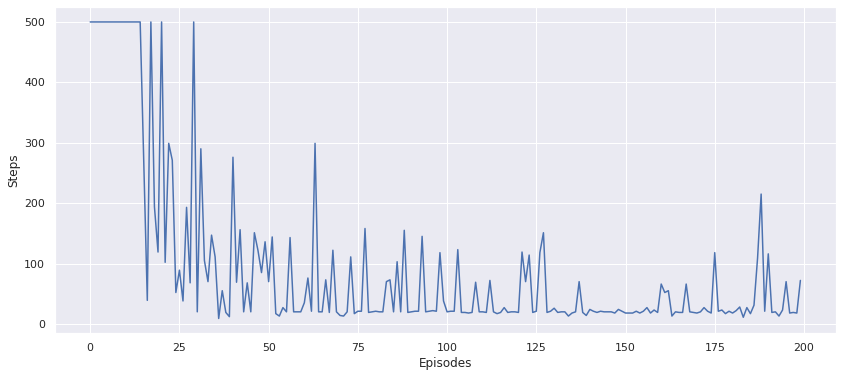

In [27]:
generate_reward_graph(agent_a2c_ex1.episode_durations, y_label='Steps')

The graph below shows the mean number of steps over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Steps'>

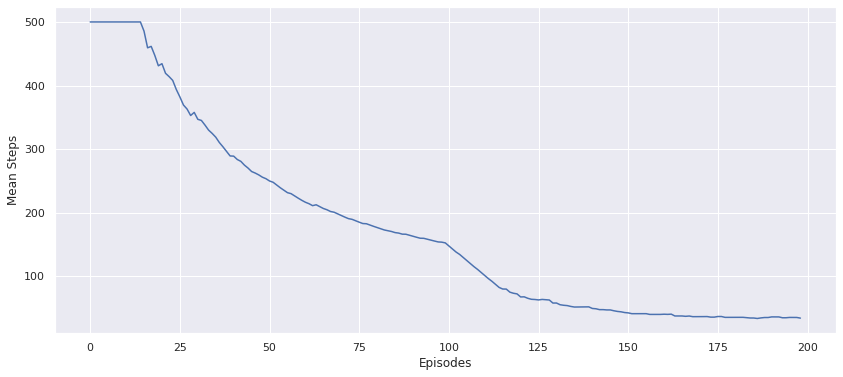

In [28]:
generate_reward_graph(agent_a2c_ex1.episode_durations, y_label='Mean Steps', avg=True)

The graph below shows the cumulative rewards for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Rewards'>

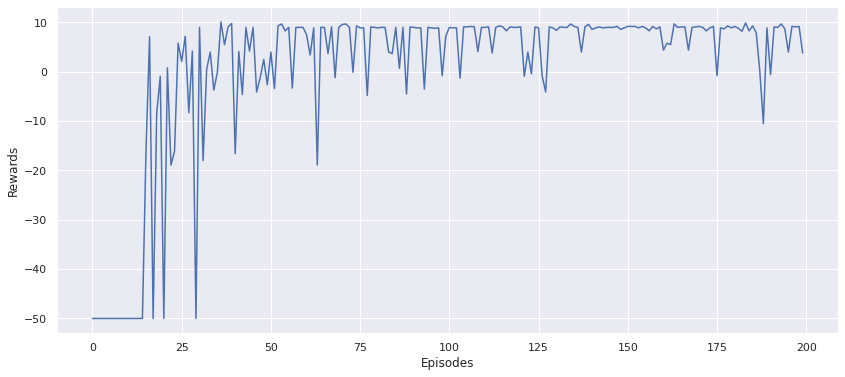

In [29]:
generate_reward_graph(agent_a2c_ex1.episode_rewards, y_label='Rewards')

The graph below shows the mean rewards over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Rewards'>

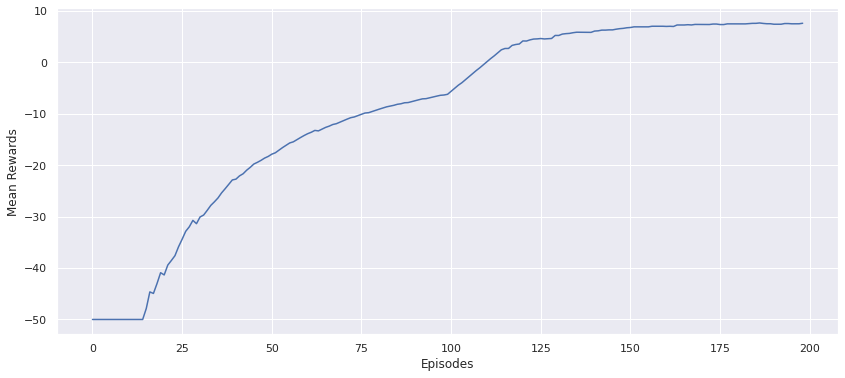

In [30]:
generate_reward_graph(agent_a2c_ex1.episode_rewards, y_label='Mean Rewards', avg=True)

## EX2 - PUSH & PULL - ONE BOX

In [31]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

In [32]:
def evaluate_agent_on_random_envs(env, agent, start_seed=1000, num_envs=100):
  solved_count = 0
  for i_env in range(100):
    done = False
    random.seed(start_seed + i_env)
    state = env.reset()
    state = agent.state_to_tensor(state)
    while not done:
      action = agent.select_action(state)
      next_state, reward, done, info = env.step(action.item())
      state = agent.state_to_tensor(next_state)

    solved = info['all_boxes_on_target']
    solved_count += int(solved)
    print(f'Env #{i_env + 1:<3} - {"not " if not solved else ""}solved')
  print(f'\nSolved {solved_count}/{num_envs} environments.')

In [64]:
checkpoint_path = 'models/ex2'

### EX2 - DQN with reward shaping

#### Training - NO NEED TO RUN

In [ ]:
agent_dqn_ex2 = DQN(sok_2, fixed_env=False, reward_shaping=True, min_epsilon=0.5) 
agent_dqn_ex2.train(checkpoint_path=checkpoint_path)

Episode   1/500 - reward=-242.10	eps=0.90
Episode   2/500 - reward=-108.70	eps=0.90
Episode   3/500 - reward=-143.70	eps=0.90
Episode   4/500 - reward=11.00	eps=0.90
Episode   5/500 - reward=-223.00	eps=0.89
Episode   6/500 - reward=-0.60	eps=0.89
Episode   7/500 - reward=2.90	eps=0.89
Episode   8/500 - reward=-164.90	eps=0.89
Episode   9/500 - reward=-39.60	eps=0.89
Episode  10/500 - reward=-25.20	eps=0.89
Episode  11/500 - reward=-198.00	eps=0.89
Episode  12/500 - reward=-245.10	eps=0.89
Episode  13/500 - reward=-227.10	eps=0.89
Episode  14/500 - reward=-225.90	eps=0.88
Episode  15/500 - reward=-82.70	eps=0.88
Episode  16/500 - reward=-228.10	eps=0.88
Episode  17/500 - reward=7.70	eps=0.88
Episode  18/500 - reward=-140.90	eps=0.88
Episode  19/500 - reward=-139.00	eps=0.88
Episode  20/500 - reward=-21.80	eps=0.88
Episode  21/500 - reward=-30.60	eps=0.88
Episode  22/500 - reward=-66.60	eps=0.88
Episode  23/500 - reward=-201.80	eps=0.87
Episode  24/500 - reward=-15.20	eps=0.87
Episode  

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Episode 252/500 - reward=-9.80	eps=0.67
Episode 253/500 - reward=10.00	eps=0.67
Episode 254/500 - reward=-224.00	eps=0.67
Episode 255/500 - reward=-166.90	eps=0.67
Episode 256/500 - reward=-240.80	eps=0.67
Episode 257/500 - reward=-161.90	eps=0.66
Episode 258/500 - reward=2.70	eps=0.66
Episode 259/500 - reward=-161.00	eps=0.66
Episode 260/500 - reward=-5.10	eps=0.66
Episode 261/500 - reward=11.00	eps=0.66
Episode 262/500 - reward=-158.90	eps=0.66
Episode 263/500 - reward=-65.30	eps=0.66
Episode 264/500 - reward=-154.90	eps=0.66
Episode 265/500 - reward=-219.00	eps=0.66
Episode 266/500 - reward=-267.90	eps=0.66
Episode 267/500 - reward=-65.00	eps=0.66
Episode 268/500 - reward=-70.00	eps=0.66
Episode 269/500 - reward=-154.10	eps=0.66
Episode 270/500 - reward=-112.70	eps=0.66
Episode 271/500 - reward=-5.10	eps=0.66
Episode 272/500 - reward=-197.80	eps=0.66
Episode 273/500 - reward=-12.90	eps=0.66
Episode 274/500 - reward=-229.20	eps=0.66
Episode 275/500 - reward=-129.30	eps=0.66
Episode 2

#### Load Pre-trained model

In [34]:
agent_dqn_ex2 = DQN(sok_2, fixed_env=False, reward_shaping=True)
agent_dqn_ex2.load_model(checkpoint_path=checkpoint_path)

#### Evaluation

Video of the agent in the middle of the training

In [35]:
embed_mp4(os.path.join(checkpoint_path, 'dqn_mid.mp4'))

Video of the agent after it finished learning

In [36]:
embed_mp4(os.path.join(checkpoint_path, 'dqn_full.mp4'))

The graph below shows the number of steps it took the agent to try to solve the environment in each episode

<AxesSubplot:xlabel='Episodes', ylabel='Steps'>

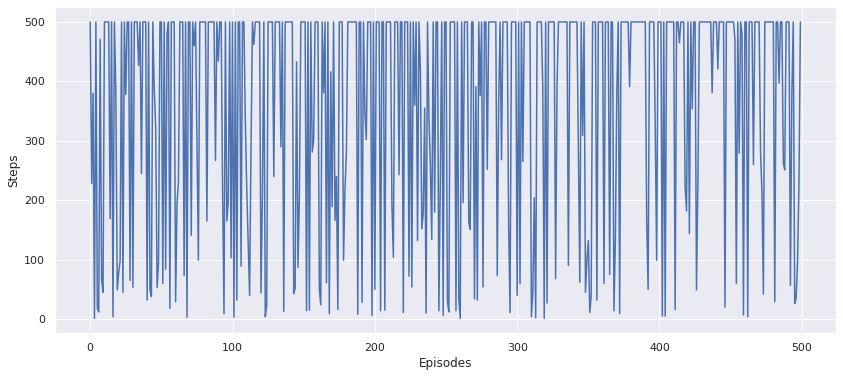

In [37]:
generate_reward_graph(agent_dqn_ex2.episode_durations, y_label='Steps')

The graph below shows the mean number of steps over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Steps'>

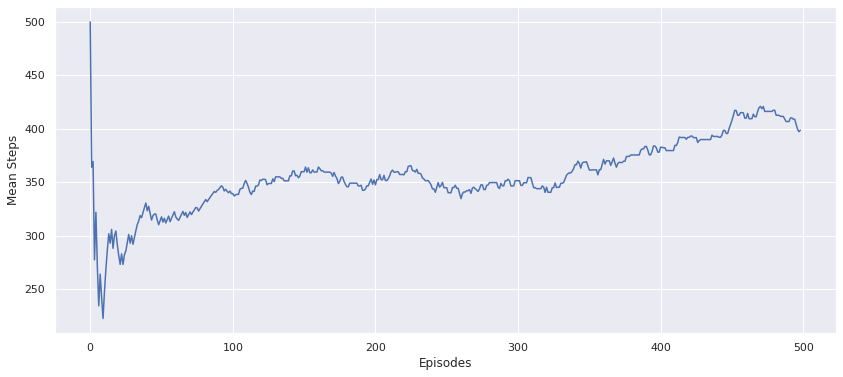

In [38]:
generate_reward_graph(agent_dqn_ex2.episode_durations, y_label='Mean Steps', avg=True)

The graph below shows the cumulative rewards for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Rewards'>

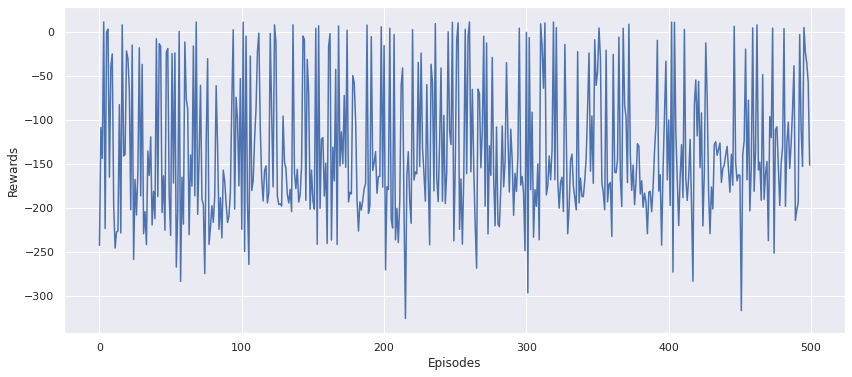

In [39]:
generate_reward_graph(agent_dqn_ex2.episode_rewards, y_label='Rewards')

The graph below shows the mean rewards over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Rewards'>

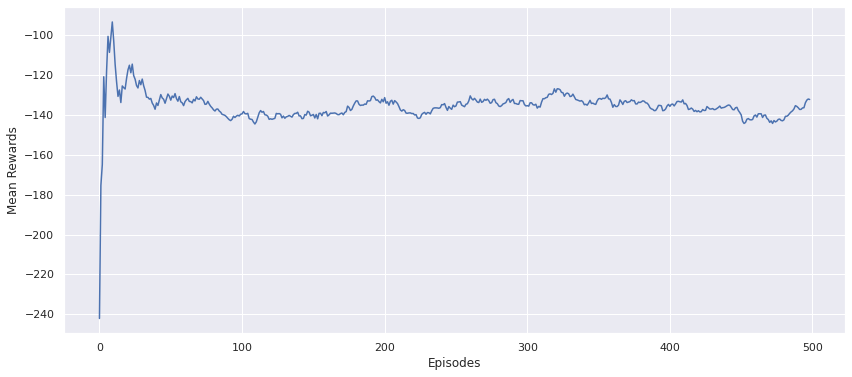

In [40]:
generate_reward_graph(agent_dqn_ex2.episode_rewards, y_label='Mean Rewards', avg=True)

Evalute the trained agent's performance over 100 random environments

In [41]:
evaluate_agent_on_random_envs(sok_2, agent_dqn_ex2, start_seed=777)

Env #1   - not solved
Env #2   - not solved
Env #3   - not solved
Env #4   - not solved
Env #5   - not solved
Env #6   - not solved
Env #7   - not solved
Env #8   - not solved
Env #9   - not solved
Env #10  - not solved
Env #11  - not solved
Env #12  - not solved
Env #13  - not solved
Env #14  - not solved
Env #15  - not solved
Env #16  - not solved
Env #17  - not solved
Env #18  - not solved
Env #19  - not solved
Env #20  - solved
Env #21  - not solved
Env #22  - not solved
Env #23  - not solved
Env #24  - not solved
Env #25  - not solved
Env #26  - not solved
Env #27  - not solved
Env #28  - not solved
Env #29  - not solved
Env #30  - not solved
Env #31  - not solved
Env #32  - not solved
Env #33  - not solved
Env #34  - not solved
Env #35  - not solved
Env #36  - not solved
Env #37  - not solved
Env #38  - not solved
Env #39  - not solved
Env #40  - not solved
Env #41  - not solved
Env #42  - solved
Env #43  - not solved
Env #44  - not solved
Env #45  - not solved
Env #46  - not sol

### EX2 - A2C with reward shaping

#### Training - NO NEED TO RUN

In [ ]:
agent_a2c_ex2 = A2C(sok_2, fixed_env=False, reward_shaping=True, min_epsilon=0.5) 
agent_a2c_ex2.train(checkpoint_path=checkpoint_path)

Episode 1/500 - reward=-233.10	eps=0.90
Episode 2/500 - reward=0.50	eps=0.90
Episode 3/500 - reward=-165.30	eps=0.90
Episode 4/500 - reward=-85.80	eps=0.90
Episode 5/500 - reward=-229.10	eps=0.89
Episode 6/500 - reward=-316.20	eps=0.89
Episode 7/500 - reward=2.20	eps=0.89
Episode 8/500 - reward=-225.00	eps=0.89
Episode 9/500 - reward=-83.30	eps=0.89
Episode 10/500 - reward=-54.10	eps=0.89
Episode 11/500 - reward=-257.90	eps=0.89
Episode 12/500 - reward=-156.80	eps=0.89
Episode 13/500 - reward=4.30	eps=0.89
Episode 14/500 - reward=-218.70	eps=0.88
Episode 15/500 - reward=-42.40	eps=0.88
Episode 16/500 - reward=-266.90	eps=0.88
Episode 17/500 - reward=-71.70	eps=0.88
Episode 18/500 - reward=-202.70	eps=0.88
Episode 19/500 - reward=-209.90	eps=0.88
Episode 20/500 - reward=8.60	eps=0.88
Episode 21/500 - reward=-206.40	eps=0.88
Episode 22/500 - reward=-159.70	eps=0.87
Episode 23/500 - reward=-204.20	eps=0.87
Episode 24/500 - reward=-165.80	eps=0.87
Episode 25/500 - reward=-28.40	eps=0.87
Ep

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Episode 252/500 - reward=7.80	eps=0.67
Episode 253/500 - reward=-133.10	eps=0.67
Episode 254/500 - reward=-183.70	eps=0.67
Episode 255/500 - reward=-136.00	eps=0.66
Episode 256/500 - reward=-216.90	eps=0.66
Episode 257/500 - reward=-104.90	eps=0.66
Episode 258/500 - reward=-37.20	eps=0.66
Episode 259/500 - reward=-153.20	eps=0.66
Episode 260/500 - reward=10.60	eps=0.66
Episode 261/500 - reward=11.00	eps=0.66
Episode 262/500 - reward=-150.80	eps=0.66
Episode 263/500 - reward=-19.60	eps=0.66
Episode 264/500 - reward=-124.60	eps=0.66
Episode 265/500 - reward=-162.10	eps=0.66
Episode 266/500 - reward=-168.00	eps=0.66
Episode 267/500 - reward=-240.00	eps=0.66
Episode 268/500 - reward=11.00	eps=0.66
Episode 269/500 - reward=-143.10	eps=0.66
Episode 270/500 - reward=-100.00	eps=0.66
Episode 271/500 - reward=-147.90	eps=0.66
Episode 272/500 - reward=-19.00	eps=0.65
Episode 273/500 - reward=3.10	eps=0.65
Episode 274/500 - reward=-129.10	eps=0.65
Episode 275/500 - reward=-123.30	eps=0.65
Episode

#### Load Pre-trained model

In [65]:
agent_a2c_ex2 = A2C(sok)
agent_a2c_ex2.load_model(checkpoint_path=checkpoint_path)

#### Evaluation

Video of the agent in the middle of the training

In [66]:
embed_mp4(os.path.join(checkpoint_path, 'a2c_mid.mp4'))

Video of the agent after it finished learning and converged

In [67]:
embed_mp4(os.path.join(checkpoint_path, 'a2c_full.mp4'))

The graph below shows the number of steps it took the agent to try to solve the environment in each episode

<AxesSubplot:xlabel='Episodes', ylabel='Steps'>

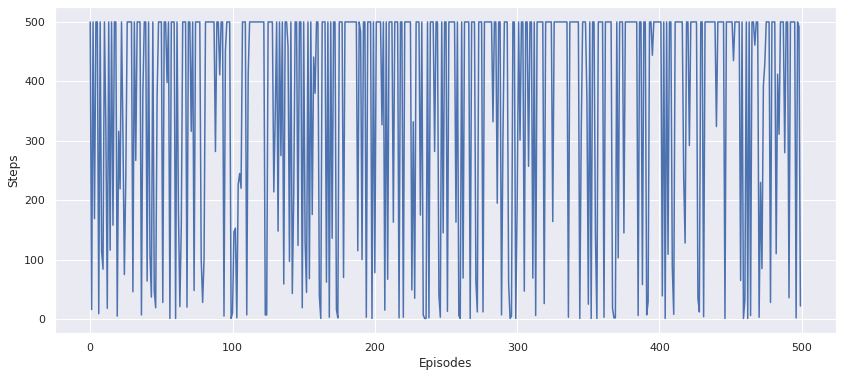

In [68]:
generate_reward_graph(agent_a2c_ex2.episode_durations, y_label='Steps')

The graph below shows the mean number of steps over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Steps'>

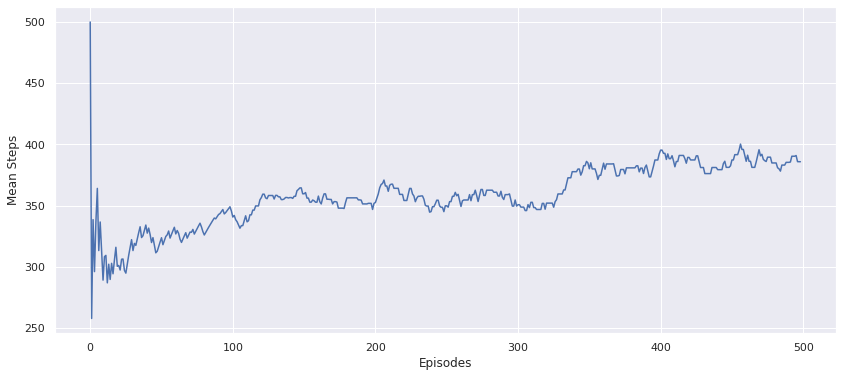

In [69]:
generate_reward_graph(agent_a2c_ex2.episode_durations, y_label='Mean Steps', avg=True)

The graph below shows the cumulative rewards for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Rewards'>

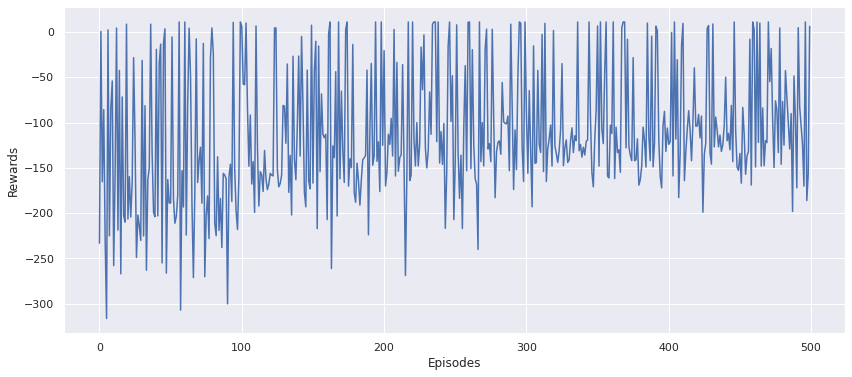

In [70]:
generate_reward_graph(agent_a2c_ex2.episode_rewards, y_label='Rewards')

The graph below shows the mean rewards over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Rewards'>

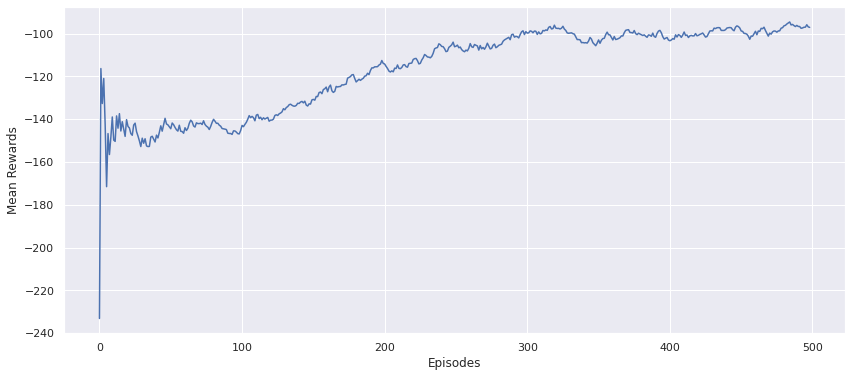

In [71]:
generate_reward_graph(agent_a2c_ex2.episode_rewards, y_label='Mean Rewards', avg=True)

Evalute the trained agent's performance over 100 random environments

In [72]:
evaluate_agent_on_random_envs(sok_2, agent_a2c_ex2, start_seed=777)

Env #1   - not solved
Env #2   - not solved
Env #3   - not solved
Env #4   - solved
Env #5   - not solved
Env #6   - not solved
Env #7   - not solved
Env #8   - solved
Env #9   - not solved
Env #10  - not solved
Env #11  - solved
Env #12  - solved
Env #13  - not solved
Env #14  - not solved
Env #15  - not solved
Env #16  - not solved
Env #17  - not solved
Env #18  - not solved
Env #19  - not solved
Env #20  - solved
Env #21  - not solved
Env #22  - not solved
Env #23  - solved
Env #24  - not solved
Env #25  - not solved
Env #26  - not solved
Env #27  - not solved
Env #28  - solved
Env #29  - not solved
Env #30  - not solved
Env #31  - not solved
Env #32  - not solved
Env #33  - not solved
Env #34  - not solved
Env #35  - solved
Env #36  - not solved
Env #37  - solved
Env #38  - not solved
Env #39  - solved
Env #40  - not solved
Env #41  - solved
Env #42  - not solved
Env #43  - not solved
Env #44  - not solved
Env #45  - not solved
Env #46  - not solved
Env #47  - solved
Env #48  - sol

#### Extra

Try to train the agent for another 500 episodes, to see if there is any improvement

In [50]:
checkpoint_path = 'models/ex2/2'

Training - NO NEED TO RUN  


In [ ]:
agent_a2c_ex2.train(checkpoint_path=checkpoint_path)

Episode 1/500 - reward=-208.90	eps=0.90
Episode 2/500 - reward=-74.00	eps=0.90
Episode 3/500 - reward=-151.90	eps=0.90
Episode 4/500 - reward=4.40	eps=0.90
Episode 5/500 - reward=-78.30	eps=0.89
Episode 6/500 - reward=-64.20	eps=0.89
Episode 7/500 - reward=0.30	eps=0.89
Episode 8/500 - reward=0.20	eps=0.89
Episode 9/500 - reward=7.50	eps=0.89
Episode 10/500 - reward=-1.70	eps=0.89
Episode 11/500 - reward=-183.90	eps=0.89
Episode 12/500 - reward=-158.10	eps=0.89
Episode 13/500 - reward=-42.60	eps=0.89
Episode 14/500 - reward=-190.00	eps=0.89
Episode 15/500 - reward=-180.00	eps=0.89
Episode 16/500 - reward=-236.10	eps=0.88
Episode 17/500 - reward=-13.90	eps=0.88
Episode 18/500 - reward=-64.30	eps=0.88
Episode 19/500 - reward=-164.10	eps=0.88
Episode 20/500 - reward=6.20	eps=0.88
Episode 21/500 - reward=-92.70	eps=0.88
Episode 22/500 - reward=-1.70	eps=0.88
Episode 23/500 - reward=-191.10	eps=0.88
Episode 24/500 - reward=-1.10	eps=0.88
Episode 25/500 - reward=9.90	eps=0.88
Episode 26/500 

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Episode 252/500 - reward=8.20	eps=0.67
Episode 253/500 - reward=-78.60	eps=0.67
Episode 254/500 - reward=-196.90	eps=0.67
Episode 255/500 - reward=-155.00	eps=0.67
Episode 256/500 - reward=-56.90	eps=0.67
Episode 257/500 - reward=-104.00	eps=0.67
Episode 258/500 - reward=-143.10	eps=0.67
Episode 259/500 - reward=-141.10	eps=0.67
Episode 260/500 - reward=-22.50	eps=0.67
Episode 261/500 - reward=-155.10	eps=0.67
Episode 262/500 - reward=-136.00	eps=0.67
Episode 263/500 - reward=-189.00	eps=0.66
Episode 264/500 - reward=-104.00	eps=0.66
Episode 265/500 - reward=-193.00	eps=0.66
Episode 266/500 - reward=-12.40	eps=0.66
Episode 267/500 - reward=-33.70	eps=0.66
Episode 268/500 - reward=-3.30	eps=0.66
Episode 269/500 - reward=-138.20	eps=0.66
Episode 270/500 - reward=-115.00	eps=0.66
Episode 271/500 - reward=-134.90	eps=0.66
Episode 272/500 - reward=-229.00	eps=0.66
Episode 273/500 - reward=4.40	eps=0.66
Episode 274/500 - reward=-154.10	eps=0.66
Episode 275/500 - reward=-132.90	eps=0.66
Episo

Load Pre-trained model

In [51]:
agent_a2c_ex2.load_model(checkpoint_path)

Evaluation

<AxesSubplot:xlabel='Episodes', ylabel='Steps'>

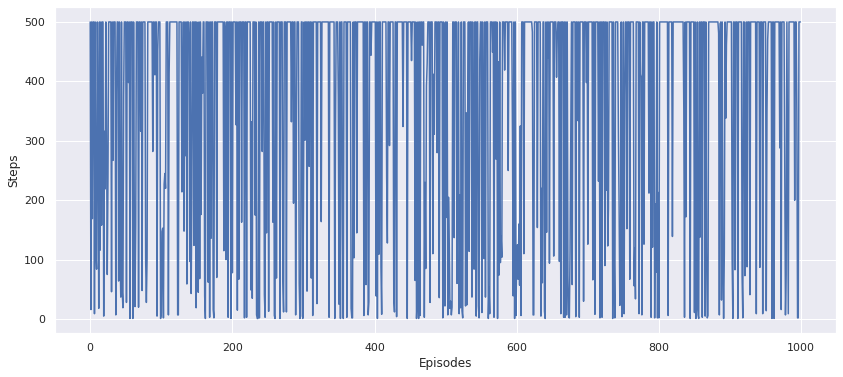

In [52]:
generate_reward_graph(agent_a2c_ex2.episode_durations, y_label='Steps')

The graph below shows the mean number of steps over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Steps'>

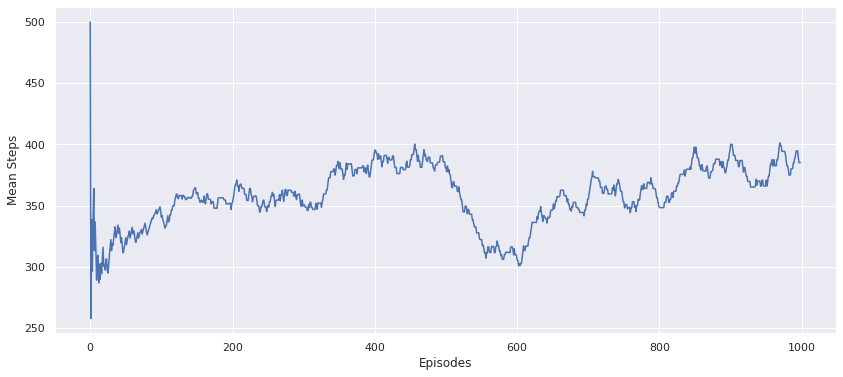

In [53]:
generate_reward_graph(agent_a2c_ex2.episode_durations, y_label='Mean Steps', avg=True)

The graph below shows the cumulative rewards for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Rewards'>

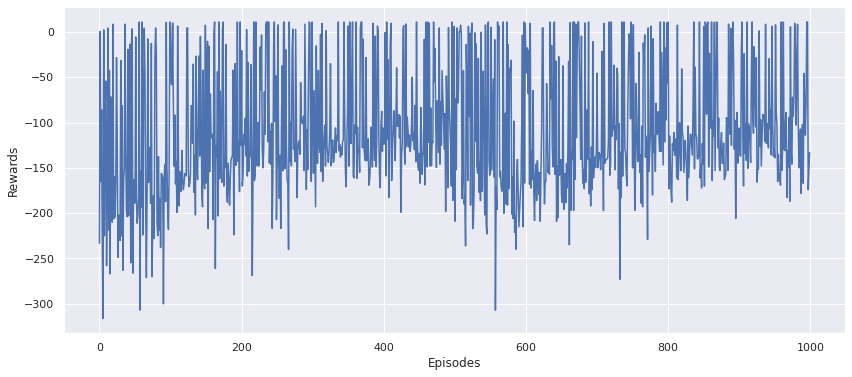

In [54]:
generate_reward_graph(agent_a2c_ex2.episode_rewards, y_label='Rewards')

The graph below shows the mean rewards over the last 100 episodes (or less), for each episode

<AxesSubplot:xlabel='Episodes', ylabel='Mean Rewards'>

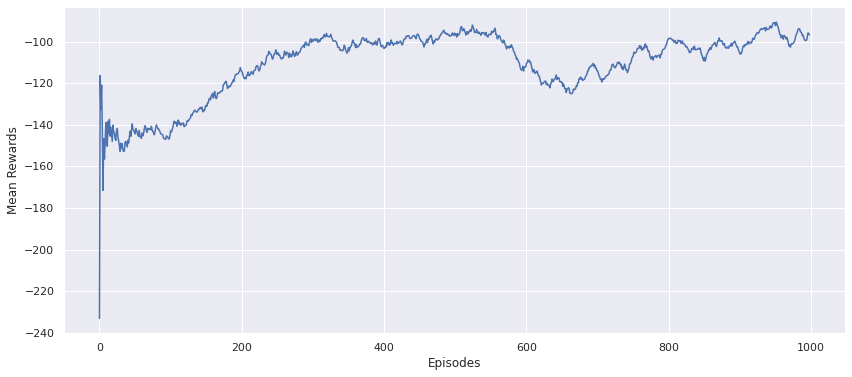

In [55]:
generate_reward_graph(agent_a2c_ex2.episode_rewards, y_label='Mean Rewards', avg=True)

Evalute the trained agent's performance over 100 random environments

In [56]:
evaluate_agent_on_random_envs(sok_2, agent_a2c_ex2, start_seed=777)

Env #1   - not solved
Env #2   - not solved
Env #3   - not solved
Env #4   - not solved
Env #5   - not solved
Env #6   - not solved
Env #7   - not solved
Env #8   - solved
Env #9   - not solved
Env #10  - not solved
Env #11  - not solved
Env #12  - solved
Env #13  - not solved
Env #14  - not solved
Env #15  - not solved
Env #16  - not solved
Env #17  - not solved
Env #18  - not solved
Env #19  - not solved
Env #20  - solved
Env #21  - not solved
Env #22  - not solved
Env #23  - not solved
Env #24  - solved
Env #25  - not solved
Env #26  - not solved
Env #27  - not solved
Env #28  - not solved
Env #29  - not solved
Env #30  - not solved
Env #31  - not solved
Env #32  - not solved
Env #33  - solved
Env #34  - not solved
Env #35  - not solved
Env #36  - not solved
Env #37  - not solved
Env #38  - solved
Env #39  - not solved
Env #40  - not solved
Env #41  - not solved
Env #42  - not solved
Env #43  - not solved
Env #44  - not solved
Env #45  - not solved
Env #46  - not solved
Env #47  - s